# Crime Prediction using Tweets and KDE

In [1]:
%matplotlib inline

import os
import glob
import itertools
import functools

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm_notebook, tqdm


from utils.consts import START_DATE, END_DATE, KDE_BANDWITH, LDA_PARAMS, LDA_TOPICS, \
                         CSV_DATE_FORMART


from utils.geo import latlng2grid_cords_chicago, \
                      latlng2LDA_topics_chicago, \
                      generate_chicago_threat_grid_list, \
                      enrich_with_chicago_grid_200, \
                      CHICAGO_UTM_COORDS, FALSE_LABLE_DATASET_CELL_SIZE, \
                      N_CHICAGO_THREAT_GRID_LIST

In [2]:
RAW_CRIMES_DATA_PATH = os.path.join('data', 'raw', 'Crimes_-_2001_to_present.csv')
PROCESSED_CRIMES_DATA_PATH = os.path.join('data', 'processed', 'crime_data.csv')

RAW_TWEETS_DATA_WILDCARD_PATH = ('"' +
                                 os.path.join('data', 'raw', 'tweets', '*.json') +
                                 '"')
PROCESSED_TWEETS_DATA_PATH = os.path.join('data', 'processed', 'tweets_data.csv')

![title](./ANLP-Project-Pipeline.png)

## Research Time Frame

In [3]:
print(START_DATE, '--->', END_DATE)

2017-12-08 ---> 2018-02-19


## Data Sources & Preprocessing

### Chicago Crimes Incidents

In [4]:
if not os.path.exists(PROCESSED_CRIMES_DATA_PATH):
    !python3 ./preprocess_crimes_data.py {RAW_CRIMES_DATA_PATH}  {PROCESSED_CRIMES_DATA_PATH}

In [5]:
crimes_data = pd.read_csv(PROCESSED_CRIMES_DATA_PATH)
crimes_data['timestamp'] = pd.to_datetime(crimes_data['timestamp'], format=CSV_DATE_FORMART).dt.normalize()

In [6]:
len(crimes_data)

10902

In [7]:
crimes_data['timestamp'].agg(['min', 'max'])

min   2017-12-08
max   2018-02-19
Name: timestamp, dtype: datetime64[ns]

### Tweets

In [8]:
if not os.path.exists(PROCESSED_TWEETS_DATA_PATH):
    !python3 -W ignore ./preprocess_tweets_data.py {RAW_TWEETS_DATA_WILDCARD_PATH} {PROCESSED_TWEETS_DATA_PATH}

In [9]:
tweets_data = pd.read_csv(PROCESSED_TWEETS_DATA_PATH)
tweets_data['timestamp'] = pd.to_datetime(tweets_data['timestamp'], format=CSV_DATE_FORMART).dt.normalize()
tweets_data['tokens'] = tweets_data['tokens'].apply(lambda x: eval(x))

In [10]:
len(tweets_data)

79634

In [11]:
tweets_data['timestamp'].agg(['min', 'max'])

min   2017-12-08
max   2018-02-19
Name: timestamp, dtype: datetime64[ns]

#### Tweets document groupping by geo-location

In [12]:
def generate_tweets_docs(tweets_data):
    tweet_docs_groupby = tweets_data.groupby(('latitude_index', 'longitude_index'))
    tweet_docs = tweet_docs_groupby['tokens'].apply(lambda r: list(r)).apply(lambda r: sum(r, []))
    tweet_docs = tweet_docs.sort_index()
    return tweet_docs

## Feature Extract Functions

### KDE

In [13]:
from sklearn.neighbors.kde import KernelDensity

def train_KDE_model(train_df, bandwith=KDE_BANDWITH):
    '''
    Train KDE model.

    Input:
    train_df: train data frame with Latitude Logitude. 3 months prior data for the day of surveillance..

    Output:
    KDE Model
    '''
    
    kde = KernelDensity(bandwidth=bandwith,
                        metric='haversine',
                        kernel='gaussian',
                        algorithm='ball_tree')
    
    kde.fit(train_df[['latitude','longitude']])
    
    return kde

In [14]:
crimes_kde_model = train_KDE_model(crimes_data)

### TODO - visualization

### Sentiment Analysis

### LDA

In [15]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def coalesce(token):
    '''
    Klaues: why this function?
    '''
    new_tokens = []
    for char in token:
        if len(new_tokens) < 2 or char != new_tokens[-1] or char != new_tokens[-2]:
            new_tokens.append(char)
    return ''.join(new_tokens)

def preprocess_tweet_for_LDA(raw_tokens):
    '''
    text input is one string
    output is tokenized and preprocessed(as defined below) text
    
    lowercase
    no hashtags or mentions
    any url converted to "url"
    replace multiple repeated chars with 2 of them. eg paaaarty -> paarty
    '''
    
    processed_tokens = []
    for token in raw_tokens:
        if token.startswith("@") or token.startswith("#"):
            continue
        elif token.startswith("https://") or token.startswith("http://"):
            processed_tokens.append("url")
        else:
            processed_tokens.append(coalesce(token))
            
    return processed_tokens

def train_LDA_model(docs, params=LDA_PARAMS, preprocessor=preprocess_tweet_for_LDA):
    
    vectorizer = CountVectorizer(stop_words="english",
                                 preprocessor=preprocessor,
                                 tokenizer=lambda x:x)
    
    lda_train_data = vectorizer.fit_transform(docs)
    
    lda_model = LatentDirichletAllocation(**params)

    lda_model.fit(lda_train_data)
    
    doc_topics = lda_model.transform(lda_train_data)
    
    vocabulary = vectorizer.get_feature_names()
    
    return lda_model, doc_topics, vocabulary

In [16]:
def get_topic_top_words_LDA(topic_index, lda_model, vocabulary, n_top_words):
    topic = lda_model.components_[topic_index]
    return [vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
            
def print_top_words_LDA(lda_model, vocabulary, n_top_words):
    for topic_idx in range(len(lda_model.components_)):
        
        message = "Topic #%d: " % topic_index
        message += " | ".join(get_topic_top_words_LDA(topic_index, lda_model, vocabulary, n_top_words))

        print(message)
    print()
    
# print_top_words_LDA(tweets_lda_model, tweets_vocabulary, 5)    



## Generate Train & Evaluatuin Datasets Functions

In [17]:
def generate_one_step_train_dataset(crimes_dataset, tweets_dataset):
    crimes_kde_model = train_KDE_model(crimes_dataset)
    
    tweets_docs = generate_tweets_docs(tweets_dataset)
    
    tweets_lda_model, doc_topics, tweets_vocabulary = train_LDA_model(tweets_docs.tolist())
    
    get_tweets_topic_top_words_LDA = functools.partial(get_topic_top_words_LDA,
                                                       lda_model=tweets_lda_model,
                                                       vocabulary=tweets_vocabulary,
                                                       n_top_words=5)

    latlng2LDA_tweet_topics_chicago = functools.partial(latlng2LDA_topics_chicago,
                                                    doc_topics=doc_topics,
                                                    docs=tweets_docs)

    chicago_grid_mask = lambda lat, lng: latlng2grid_cords_chicago(lat, lng) in tweets_docs.index
    
    train_dataset = pd.concat([crimes_data[['latitude', 'longitude']].assign(crime=True),
                            generate_chicago_threat_grid_list().assign(crime=False)],
                    axis=0)


    train_dataset = train_dataset[['latitude', 'longitude', 'crime']]
    train_dataset = enrich_with_chicago_grid_200(train_dataset)

    train_dataset['KDE'] = crimes_kde_model.score_samples(
        train_dataset[['latitude', 'longitude']].as_matrix()
    )

    train_dataset[LDA_TOPICS] = train_dataset.apply(lambda row: pd.Series(latlng2LDA_tweet_topics_chicago(
                                                                    row['latitude'],
                                                                    row['longitude'])),
                                        axis=1)

    features_cols = ['KDE'] + LDA_TOPICS

    train_dataset = {
                    'X': train_dataset[['latitude_index', 'longitude_index'] + features_cols],
                    'Y': train_dataset['crime']
    }
    
    return train_dataset


def generate_one_step_evaluation_dataset(crimes_evaluation_dataset):
    evaluation_dataset = enrich_with_chicago_grid_200(crimes_evaluation_dataset)
    evaluation_dataset = evaluation_dataset[['latitude_index', 'longitude_index']]
    return evaluation_dataset


def generate_one_step_datasets(crimes_data, tweets_data, start_train_date, n_train_days):
    start_train_date = pd.to_datetime(start_train_date)

    end_train_date = start_train_date + pd.DateOffset(n_train_days)
    evaluation_date = end_train_date + pd.DateOffset(1)
    
    crimes_train_dataset = crimes_data[(crimes_data['timestamp'] >= start_train_date) &
                                       ((crimes_data['timestamp'] <= end_train_date))]
    
    tweets_train_dataset = tweets_data[(tweets_data['timestamp'] >= start_train_date) &
                                       ((tweets_data['timestamp'] <= end_train_date))]
    
    crimes_evaluation_dataset = crimes_data[crimes_data['timestamp'] == evaluation_date]

    train_dataset = generate_one_step_train_dataset(crimes_train_dataset, tweets_train_dataset)
    evaluation_dataset = generate_one_step_evaluation_dataset(crimes_evaluation_dataset)
    
    return train_dataset, evaluation_dataset


In [18]:
from sklearn.linear_model import LogisticRegression

def generate_threat_kde_dataset(train_dataset):
    threat_grid_cells = train_dataset['X'][~train_dataset['Y']]
    kde_values = threat_grid_cells[['latitude_index', 'longitude_index', 'KDE']]
    threat_kde_df = kde_values.set_index(['latitude_index', 'longitude_index'])['KDE']
    threat_kde_df = threat_kde_df.sort_values(ascending=False)
    return list(threat_kde_df.index)

def generate_threat_logreg_dataset(train_dataset):
    is_crime_count = train_dataset['Y'].value_counts()
    logreg_C = is_crime_count[False] / is_crime_count[True]
    logreg = LogisticRegression(C=logreg_C)
    logreg.fit(train_dataset['X'][['KDE'] + LDA_TOPICS], train_dataset['Y'])
    
    threat_grid_cells = train_dataset['X'][~train_dataset['Y']]

    threat_grid_cells['logreg'] = logreg.predict_log_proba(threat_grid_cells[['KDE'] + LDA_TOPICS])[:, 1]
    logreg_values = threat_grid_cells[['latitude_index', 'longitude_index', 'logreg']]

    threat_logreg_df = logreg_values.set_index(['latitude_index', 'longitude_index'])['logreg']
    threat_logreg_df = threat_logreg_df.sort_values(ascending=False)
    
    return list(threat_logreg_df.index) 

def generate_threat_datasets(train_dataset):
    
    return [generate_threat_kde_dataset(train_dataset),
            generate_threat_logreg_dataset(train_dataset)]

In [42]:
def generate_surveillance_data(train_dataset, evaluation_dataset):

    surveillance_data = np.zeros((3, N_CHICAGO_THREAT_GRID_LIST))

    threat_datasets = generate_threat_datasets(train_dataset)

    crime_counts = evaluation_dataset.groupby(['latitude_index', 'longitude_index']).size()
    crime_counts = crime_counts.sort_values(ascending=False)

    # real crime occurence is our gold dataset
    threat_datasets.append(list(crime_counts.index))
    
    for threat_model_index, threat_dataset in enumerate(threat_datasets):
        for cell_index, (latitude_index, longitude_index) in enumerate(threat_dataset):
            surveillance_data[threat_model_index][cell_index] = crime_counts.get((latitude_index, longitude_index), 0)
        
    return surveillance_data
    
    
def generate_one_step_surveillance_data(crimes_data, tweets_data, start_train_date, n_train_days):
    
        train_dataset, evaluation_dataset = generate_one_step_datasets(crimes_data,
                                                                       tweets_data,
                                                                       start_train_date,
                                                                       n_train_days)

        surveillance_data = generate_surveillance_data(train_dataset,
                                                        evaluation_dataset)
        
        return surveillance_data

    
def generate_all_data_surveillance_data(crimes_data, tweets_data, n_train_days):
    surveillance_data = np.zeros((3, N_CHICAGO_THREAT_GRID_LIST))

    for start_train_date in tqdm(pd.date_range(START_DATE, END_DATE)[:-(n_train_days+1)]):
        
        surveillance_data +=  generate_one_step_surveillance_data(crimes_data,
                                                                  tweets_data,
                                                                  start_train_date,
                                                                  n_train_days)


#        surveillance_data = surveillance_data.cumsum(axis=0)
#        surveillance_data /= surveillance_data.sum(axis=0)
        
    return surveillance_data

def plot_surveillance_data(surveillance_data):
    pass


In [53]:
train_dataset, evaluation_dataset = generate_one_step_datasets(crimes_data,
                                                               tweets_data,
                                                               pd.to_datetime(START_DATE),
                                                               2)


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [74]:
threat_grid_cells = train_dataset['X'][~train_dataset['Y']]
kde_values = threat_grid_cells[['latitude_index', 'longitude_index', 'KDE']]
threat_kde_df = kde_values.set_index(['latitude_index', 'longitude_index'])['KDE']
threat_kde_df = threat_kde_df.sort_values(ascending=False)

In [100]:
a = kde_values[['latitude_index', 'longitude_index']]
a = [tuple(x) for x in a.as_matrix()]
len(a)- len(set(a))

218

In [ ]:
'longitude': -87.94011,
                         'latitude': 41.64454}, 

In [140]:
from utils.geo import _generate_utm_columns, CHICAGO_UTM_COORDS, _utm2latlng, _generate_utm_columns

NameError: name '_generate_utm_columns' is not defined

In [143]:
utm_latitude_dim = np.arange(CHICAGO_UTM_COORDS['ll']['latitude'],
                             CHICAGO_UTM_COORDS['ur']['latitude'],
                             200)

utm_longitude_dim = np.arange(CHICAGO_UTM_COORDS['ll']['longitude'],
                              CHICAGO_UTM_COORDS['ur']['longitude'],
                              200)

utm_grid_list = [{'utmlat': lat,
                  'utmlng': lng}
                 for lat, lng in itertools.product(utm_latitude_dim,
                                                   utm_longitude_dim)]
for cord in utm_grid_list:
    cord.update(_utm2latlng({'latitude': cord['utmlat'], 'longitude': cord['utmlng']}))

In [146]:
utm_grid_df = pd.DataFrame(utm_grid_list)
utm_grid_df.head()

,latitude,longitude,utmlat,utmlng
0,41.644540,-87.940110,421710.112402,4.610738e+06
1,41.646341,-87.940136,421710.112402,4.610938e+06
2,41.648142,-87.940162,421710.112402,4.611138e+06
3,41.649944,-87.940189,421710.112402,4.611338e+06
4,41.651745,-87.940215,421710.112402,4.611538e+06


In [152]:
utm_grid_df.loc[:, 'latitude_index_utm'] = (((utm_grid_df['utmlat'] - CHICAGO_UTM_COORDS['ll']['latitude'])
                                / 200)
                               .astype(int))

utm_grid_df.loc[:, 'longitude_index_utm'] = (((utm_grid_df['utmlng'] - CHICAGO_UTM_COORDS['ll']['longitude'])
                                 / 200)
                                .astype(int))

In [154]:
utm_grid_df.head()

,latitude,longitude,utmlat,utmlng,latitude_index_utm,longitude_index_utm
0,41.644540,-87.940110,421710.112402,4.610738e+06,0,0
1,41.646341,-87.940136,421710.112402,4.610938e+06,0,1
2,41.648142,-87.940162,421710.112402,4.611138e+06,0,2
3,41.649944,-87.940189,421710.112402,4.611338e+06,0,3
4,41.651745,-87.940215,421710.112402,4.611538e+06,0,4


In [156]:
foo = utm_grid_df[['latitude', 'longitude']].apply(lambda row: _generate_utm_columns(row), axis=1)


In [163]:
utm_grid_df = pd.concat([utm_grid_df, foo.rename({'latitude':'enutmlat', 'longitude': 'enutmlng'}, axis=1)], axis=1)

In [168]:
(utm_grid_df['utmlat'] - utm_grid_df['enutmlat']).describe()

count    36575.000000
mean         0.002807
std          0.001326
min          0.000939
25%          0.001628
50%          0.002593
75%          0.003877
max          0.005545
dtype: float64

In [165]:
utm_grid_df.head(3)

,latitude,longitude,utmlat,utmlng,latitude_index_utm,longitude_index_utm,latitude_index,longitude_index,enutmlat,enutmlng
0,41.644540,-87.940110,421710.112402,4.610738e+06,0,0,0,0,421710.106857,4.610738e+06
1,41.646341,-87.940136,421710.112402,4.610938e+06,0,1,0,0,421710.106857,4.610938e+06
2,41.648142,-87.940162,421710.112402,4.611138e+06,0,2,0,1,421710.106857,4.611138e+06


In [148]:
import collections
(set(collections.Counter(((utm_grid_df['utmlat'] - CHICAGO_UTM_COORDS['ll']['latitude']) / 200).astype(int)).values()),
 set(collections.Counter(((utm_grid_df['utmlng'] - CHICAGO_UTM_COORDS['ll']['longitude']) / 200).astype(int)).values()))

({209}, {175})

,latitude,longitude,latitude_index,longitude_index
0,41.644540,-87.940110,0,0
1,41.646341,-87.940136,0,0
2,41.648142,-87.940162,0,1
3,41.649944,-87.940189,0,2
4,41.651745,-87.940215,0,3
5,41.653546,-87.940241,0,4
6,41.655347,-87.940267,0,5
7,41.657148,-87.940293,0,6
8,41.658950,-87.940320,0,7
9,41.660751,-87.940346,0,8


In [99]:
a[1] == a[0]

True

In [77]:
N_CHICAGO_THREAT_GRID_LIST, 174 * 209

(36575, 36366)

In [85]:
list(threat_grid_cells[x])

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 9.950248756223529e-06,
 9.950248756223529e-06,
 9.950248756223529e-06,
 9.950248756223529e-06,
 9.950248756223529e-06,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.405405405405444e-05,
 5.405405405405444e-05,
 5.405405405405444e-05,
 5.405405405405444e-05,
 5.405405405405444e-05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0002857142857143005,
 0.0002857142857143005,
 0.0002857142857143005,
 0.0002857142857143005,
 0.0002857142857143005,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [20]:
q = generate_all_data_surveillance_data(crimes_data, tweets_data, 31)

  0%|          | 0/42 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1356: Runt

([<matplotlib.axis.YTick at 0x121276518>,
 <a list of 6 Text yticklabel objects>)

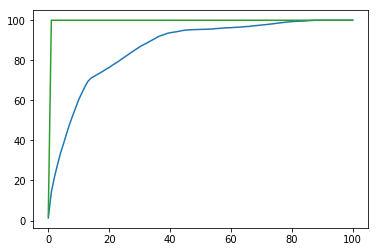

In [35]:
step = int(q.shape[1] / 100)
qq = (q.cumsum(axis=1) / q.sum(axis=1)[:,None])[:,::step]

plt.plot(qq[0])
plt.plot(qq[1][::step])
plt.plot(qq[2])
plt#.plot(qq[1] - qq[0])
plt.xticks(range(0, 120, 20))
plt.yticks(np.arange(0, 1.2, 0.2), range(0, 120, 20))

In [36]:
qq[2,:]

array([ 0.0221396,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       ,  1.       ,  1.    